# 05. Features Engineering

In [1]:
from IPython.display import HTML, Image
import pandas as pd
data = pd.read_csv("data/data.csv").dropna()
data.head(3)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00


## –– Sommaire

### F. Réduction dimensionnelle linéaire

• PCA  
• NMF  
• Factor Analysis  

### G. Réduction dimensionnelle non-linéaire

• ACP à noyau  
• Clustering hiérarchique  
• K-Means  
• DBSCAN  

## From cat to num



In [2]:
data['state'] = data['state'].astype("category").cat.codes

In [3]:
data.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,1,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,1,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,1,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,1,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,0,14,US,1283.0,1283.0,19500.00


## F. Réduction de dimensions linéaire

### –– ACP (PCA)
- se concentrer sur la maximisation de la variance selon les axes (au détriment du caractère explicatif des axes)...
- ...en définissant des axes orthogonaux appelés composantes principales.

In [4]:
data_PCA = data.drop(['launched', 'name', 'ID', 'deadline', 'country', 'currency', 'main_category', 'category'], axis=1)

#Standardiser les données pour les comparer entre elles peu importe l'unité
from sklearn import preprocessing

std_scale = preprocessing.StandardScaler().fit(data_PCA)
data_scaled = std_scale.transform(data_PCA)

#Calcul des composantes principales
from sklearn import decomposition

pca = decomposition.PCA(n_components=2)
pca.fit(data_scaled)

#Pourcentage de variance expliquée
print(pca.explained_variance_ratio_) #par composantes
print(pca.explained_variance_ratio_.sum()) #en cumulé

[0.49575682 0.27767067]
0.773427492128723


In [5]:
# projeter X sur les composantes principales
X_projected = pca.transform(data_scaled)

In [6]:
#Afficher les poids des composantes principales
pcs = pca.components_
print(data_PCA.head(0))
print(pd.DataFrame(pcs))

Empty DataFrame
Columns: [goal, pledged, state, backers, usd pledged, usd_pledged_real, usd_goal_real]
Index: []
          0         1         2         3         4         5         6
0  0.005864  0.511379  0.084768  0.453941  0.501177  0.523447  0.005791
1  0.706690 -0.002181 -0.034488 -0.003619 -0.002055 -0.002912  0.706661


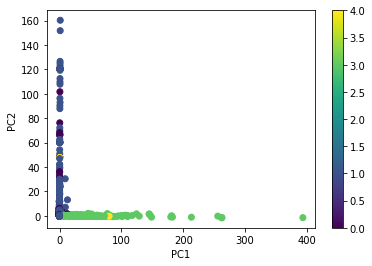

In [7]:
#Visualiser les observations sur les composantes principales, en fonction d'une variable initiale
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(X_projected[:, 0], X_projected[:, 1], c=data.get('state'))
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar()
plt.show()

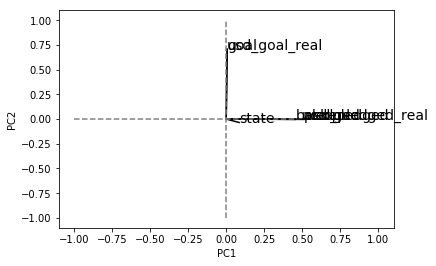

In [8]:
for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    #Afficher un segment de l'origine au point (x, y)
    plt.plot([0, x], [0, y], color='k')
    #Afficher le nom (data.columns[i]) de la performance
    plt.text(x, y, data_PCA.columns[i], fontsize='14')

#Afficher une ligne verticale x=0
plt.plot([0, 0], [-1, 1], color='grey', ls='--')
plt.xlabel('PC1')

#Afficher une ligne horizontale y=0
plt.plot([-1, 1], [0, 0], color='grey', ls='--')
plt.ylabel('PC2')

plt.show()

### –– Non-negative matrix factorization (NMF)
Si les composantes principales d'une ACP sont difficiles à interpréter (valeurs négatives, d'autres positives...), on peut envisager une NMF qui va nous permettre d'obtenir des composantes avec des valeurs exclusivement positives et plus interprétables.  

- il faut que la matrice de données soit exclusivement positive...
- ...et la NMF forcera les valeurs des composantes à être positives.
- utile pour découvrir des thèmes.

*Elle permet aussi de prédire les valeurs manquantes de notre matrice de données.* 

### –– Analyse factorielle (Factor Analysis)

L'analyse factorielle postule que les données observées sont le fruit d'une combinaison linéaire de facteurs latents qu'il faut découvrir, au détriment de la qualité de la variance expliquée sur laquelle se concentre l'ACP ou la NMF.

- modélise la structure de convariance entre les variables observées...
- ...sans nécessairement définir des axes orthogonaux.
- utile pour découvrir des variables latentes

## G. Réduction de dimensions non-linéaire

Quand le pourcentage de variance expliquée à l'issue des réductions dimensionnelles linéaires est trop faible, on se tourne vers des méthodes non-linéaires.

### –– ACP à noyau

### –– Clustering hiérarchique

- Le Clustering hiérarchique est adapté à des petits datasets (complexité algorithmique lourde).
- Il n'est pas nécessaire de définir le nombre de clusters à l'avance (on explore toutes les possibilités). 

À chaque étape, on agrège les deux clusters les plus proches. La distance (paramètre `linkage:`) peut être calculée :
- Lien simple (`single`) : la distance entre deux clusters est celle entre les deux points les plus proches.
- Lien complet (`complete`) : la distance entre deux clusters est celle entre les deux points les plus éloignés.
- Lien moyen (`average`) : la distance entre deux clusters est la distance moyenne entre les points des deux clusters.
- Clustering de Ward (`ward`) : la distance entre deux clusters est calculée de façon à minimiser la variance inter-cluster.

### –– K-means

- Efficace en temps de calcul (k étant fixé).
- Toutefois, il est nécessaire de réitérer avec un nouveau k pour tester une initialisation différente.
- Quand k est petit, K-means est sensible aux outliers.

K-Means: Algo explained:
we init k initial centroids (with k the number of clusters we want). Note that our final clusters are sensitive to our initial centroids.
samples are assigned to the closest centroid, making a cluster
then a new centroid is defined as the mean of cluster
then we reassigned samples to the new closest centroid and recalculate a new centroid etc. until a stopping criteria is reached

How to choose k:
- Have a visually approach of the potential number of clusters with a scatterplot.
- Do some features reduction (dimensional reductions) to better visualize.
- Use domain knowledge like for a retailer, the number of categories of its products, or for a location survey, the number of regions that you want to analyze.
- Elbow Method (les coudes de cattell ommgg ???): We plot the WSSE (y) by the number of clusters k (x). We choose k where the curve stop dropping, or a possible range of k if it’s too ambiguous.

How to choose a stopping criterion:
Natural if there is no more changes after recalculation of centroids but we can’t add a stopping criteria like stop when the number of samples change in clusters is below your criterion like 1% for example.

Model accuracy :
- WSSE (Within cluster Sum of Squared Error)
It only make sense to measure the WSSE when same k and from the same dataset.
Larger k will always reduce WSSE.
Warning: if WSSE1 < WSSE2, it does’t mean that model1 is better than model2. The minimal WSSE is not always the best.

Interpretation:
Clusters’ centroids are like a representative sample of a cluster, so we can compare the centroids between them to see the differences

In [9]:
from sklearn.cluster import KMeans

Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_scaled)
    Sum_of_squared_distances.append(km.inertia_)

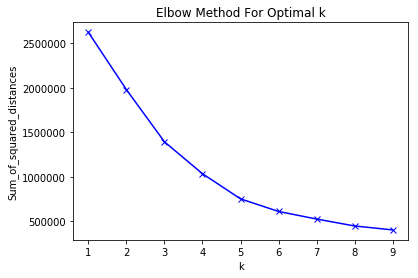

In [11]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

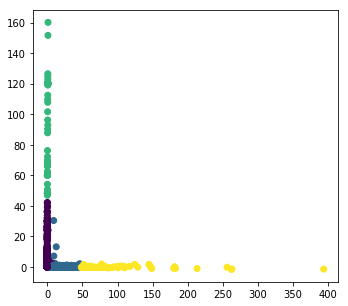

In [14]:
from sklearn import cluster, metrics
fig = plt.figure(figsize=(12, 5))

kmeans = cluster.KMeans(n_clusters=4)
kmeans.fit(data_scaled)
ax = fig.add_subplot(121)
ax.scatter(X_projected[:, 0], X_projected[:, 1], c=kmeans.labels_)

### –– DBSCAN

- peu adapté au grands jeux de données de part le peu de densité.
- 

DBSCAN itère sur les points du jeu de données. Pour chacun des points qu'il analyse, il construit l'ensemble des points atteignables par densité depuis ce point : il calcule l'epsilon-voisinage de ce point, puis, si ce voisinage continent plus de n_min points, les epsilon-voisinages de chacun d'entre eux, et ainsi de suite, jusqu'à ne plus pouvoir agrandir le cluster. Si le point considéré n'est pas un point intérieur, c'est à dire qu'il n'a pas suffisamment de voisins, il sera alors étiqueté comme du bruit. Cela permet à DBSCAN d'être robuste aux données aberrantes puisque ce mécanisme les isole.